In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import math
from scipy import stats

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Read and merge data

In [2]:
# Read the data from csv
moq_data = pd.read_csv("moq_data.csv", delimiter=';', index_col='material')
inventory_level = pd.read_csv("inventory_level.csv", delimiter=';', index_col='material')
demand = pd.read_csv("demand.csv", delimiter=';', index_col='material')

# Merge data
data = pd.concat([moq_data, inventory_level, demand], axis=1)


## Run simulation

In [ ]:
# Define the list of materials
materials = moq_data.index.unique()

# Initialize empty dataframes for results
average_inventory_on_hand = pd.DataFrame(index=materials, columns=["Average Inventory on Hand"])
fill_rate = pd.DataFrame(index=materials, columns=["Fill Rate"])
total_order_quantity = pd.DataFrame(index=materials, columns=["Total Order Quantity"])

# Initialize array and moq parameters for multiple simulations
results_array = []
moq_simulation_values = [1, 0.9, 0.8, 0.7, 0.50]

# Run simulation for each material
def runSimulation(moq_simulation_value):
    for material in materials:
        print(f'Starting simulation for material: {material}')
        print(f'{"Week":<5} {"D":<7} {"Q":<7} {"O":<7} {"IP":<12} {"netstockarrival":<15} {"netstockafter":<15} {"ud":<7}')

        # Subset data for the current material
        data_sub = data.loc[material]

        # Create empty dataframes for Q, O, IP, and netstockafter, netstockarrival, ud
        Q = pd.DataFrame(index=range(1, 54), columns=[material])
        O = pd.DataFrame(index=range(1, 54), columns=[material])
        IP = pd.DataFrame(index=range(1, 54), columns=[material])
        netstockafter = pd.DataFrame(index=range(1, 54), columns=[material])
        netstockarrival = pd.DataFrame(index=range(1, 54), columns=[material])
        ud = pd.DataFrame(index=range(1, 54), columns=[material])

        # Initialize the dataframes with zeros
        Q.loc[:] = 0
        O.loc[:] = 0
        IP.loc[:] = 0
        netstockafter.loc[:] = 0
        netstockarrival.loc[:] = 0
        ud.loc[:] = 0

        L = 8

        # max_t = min(54, len(data_sub) - L - int(data_sub['lot_size']))
        max_t = 54

        # Loop for max_t weeks
        for t in range(1, max_t):

            if ((material == 2171413 and t == 1)):
                # print("here")
                pass

            # Weekly demand
            demand_t = data_sub[str(t)]

            # inventory position calculation rule
            IP.loc[t] = netstockafter.loc[t-1] if t > 1 else data_sub['IP']
            
            O_sum = O.iloc[t-1:t+L-1].sum()
            data_sub_sum = data_sub.iloc[5+t:5+t+L].sum()

            subtract_val = 0  # default value

            # only subtract if O_sum is larger than 0
            # if O_sum.sum() > 0:
            #     # make sure the subtraction result is not less than zero
            #     subtract_val = max(0, O_sum.sum() - data_sub_sum.sum())
            subtract_val = O_sum.sum() - data_sub_sum.sum()

            # Q calculation rule
            Qtoorder = data_sub.iloc[5+t+L:5+t+L+int(data_sub['lot_size'])].sum() \
                    + data_sub['safety_stock'] \
                    - subtract_val \
                    - IP.iloc[t-1]

            # Order rule 1, Order rule 2, Order rule 3
            moq = data_sub['moq'] * moq_simulation_value
            Q.loc[t] = np.where(Qtoorder < 0, 0,
                        np.where((1 > Qtoorder/moq) & (Qtoorder/moq > 0), moq,
                        np.where(Qtoorder > moq, moq + np.ceil((Qtoorder - moq) / data_sub['rounding_value']) * data_sub['rounding_value'], 0)))

            # Instead of setting order arrival for current week
            # O.loc[t] = Q.loc[t-8] if t > 8 else 0

            # You set order arrival for future week when placing order
            if t <= max_t - L:  # Ensure that we don't go beyond max_t
                O.loc[t+L] = Q.loc[t]

            # Stock calculation rules
            netstockarrival.loc[t] = IP.loc[t] + O.loc[t]  # Netstockbefore
            netstockafter.loc[t] = netstockarrival.loc[t] - data_sub[str(t)]  # Netstockafter

            # Unserved demand rule
            ud.loc[t] = np.where(data_sub[str(t)] < netstockarrival.loc[t], 0, np.minimum(data_sub[str(t)], data_sub[str(t)] - netstockarrival.loc[t]))

            # Print the values
            # print(f'{t:<5} {demand_t:<7.1f} {Q.loc[t][material]:<7.1f} {O.loc[t][material]:<7.1f} {IP.loc[t][material]:<12.1f} {netstockarrival.loc[t][material]:<15.1f} {netstockafter.loc[t][material]:<15.1f} {ud.loc[t][material]:<7.1f}')


        # Compute metrics for the current material and store them
        netstock_sum = netstockafter[netstockafter >= 0].sum().values # only take into account nonnegative netstock
        average_inventory_on_hand.loc[material] = math.ceil(netstock_sum / 53)

        total_order_quantity.loc[material] = math.ceil(O.sum().values)
    

        if (data_sub[6:].values.sum() == 0):
            fill_rate.loc[material] = 1
        else:
            fill_rate.loc[material] = 1 - ud.sum().values / data_sub[6:].values.sum()

    return pd.concat([average_inventory_on_hand, total_order_quantity, fill_rate], axis=1)

# Concatenate results
# results = pd.concat([average_inventory_on_hand, total_order_quantity, fill_rate], axis=1)

for moq_simulation_value in moq_simulation_values:
    print(f'\n\nRunning simulation with moq_simulation_value: {moq_simulation_value}\n\n')
    result = runSimulation(moq_simulation_value)
    results_array.append({'moq_simulation_value': moq_simulation_value, 'result': result})



## Display raw results

In [ ]:
pd.set_option('display.max_rows', 100)

# Display results
# display(results_array)
for result in results_array:
    display('', '', f'moq_simulation_value: {result["moq_simulation_value"]}')
    avg_inventory = round(result["result"]['Average Inventory on Hand'].mean(), 1)
    avg_order_qty = round(result["result"]['Total Order Quantity'].mean(), 1)
    avg_fill_rate = round(result["result"]['Fill Rate'].mean(), 4)
    display(f"Average of 'Average Inventory on Hand': {avg_inventory}")
    display(f"Average of 'Total Order Quantity': {avg_order_qty}")
    display(f"Average of 'Fill Rate': {avg_fill_rate}")
    display(result["result"])




## Display precentage difference between moq simulation values

In [5]:
# Transform the list of dictionaries to a dictionary of DataFrames
results_dict = {item['moq_simulation_value']: item['result'] for item in results_array}

# Get the reference DataFrame (where moq_simulation_value is 1)
reference_df = results_dict[1]

# Initialize an empty DataFrame to store the results
comparison_df = pd.DataFrame(columns=['moq_simulation_value', 'Average Inventory on Hand delta %', 'Average Order Quantity delta %'])

# Go through all the dataframes in the dictionary
for moq_value, df in results_dict.items():
    # if moq_value == 1:  # Skip the reference
    #     continue

    # Ignore the materials where the 'Average Inventory on Hand' or 'Total Order Quantity' in the reference dataframe is zero
    nonzero_inventory = reference_df['Average Inventory on Hand'] != 0
    nonzero_order_quantity = reference_df['Total Order Quantity'] != 0
    valid_materials = nonzero_inventory & nonzero_order_quantity

    # Calculate the absolute percentage difference for 'Average Inventory on Hand' and 'Total Order Quantity'
    inventory_diff = ((df.loc[valid_materials, 'Average Inventory on Hand'] - reference_df.loc[valid_materials, 'Average Inventory on Hand']) / reference_df.loc[valid_materials, 'Average Inventory on Hand']) * 100
    order_quantity_diff = ((df.loc[valid_materials, 'Total Order Quantity'] - reference_df.loc[valid_materials, 'Total Order Quantity']) / reference_df.loc[valid_materials, 'Total Order Quantity']) * 100

    # Calculate the average difference for all valid materials
    inventory_avg_diff = inventory_diff.mean()
    order_quantity_avg_diff = order_quantity_diff.mean()

    # Rounf inventory_avg_diff and order_quantity_avg_diff
    inventory_avg_diff = round(inventory_avg_diff, 2)
    order_quantity_avg_diff = round(order_quantity_avg_diff, 2)

    # Append the results to the comparison dataframe
    new_row = pd.DataFrame({'moq_simulation_value': [moq_value], 'Average Inventory on Hand delta %': [inventory_avg_diff], 'Average Order Quantity delta %': [order_quantity_avg_diff]})
    comparison_df = pd.concat([comparison_df, new_row])

# Set moq_simulation_value as index
comparison_df.set_index('moq_simulation_value', inplace=True)

# Display the dataframe
display(comparison_df)


,Average Inventory on Hand delta %,Average Order Quantity delta %
moq_simulation_value,,
1,0.00,0.00
0.9,-5.33,-4.58
0.8,-12.43,-8.31
0.7,-19.34,-13.23
0.5,-31.92,-19.81


## Display average fill rate of each simulation

In [ ]:

# Initialize an empty DataFrame
# final_df = pd.DataFrame(columns=['moq_simulation_value', 'Average of Average Inventory on Hand', 'Average of Fill Rate', 'Total Order Quantity'])
final_df = pd.DataFrame(columns=['moq_simulation_value', 'Average of Fill Rate'])

# Iterate over the list of dictionaries
for result in results_array:
    # Convert the result DataFrame to the correct data types
    result['result'] = result['result'].astype({'Average Inventory on Hand': 'float', 'Total Order Quantity': 'float', 'Fill Rate': 'float'})
    
    # Calculate the average of 'Average Inventory on Hand', 'Fill Rate' and sum of 'Total Order Quantity'
    # avg_inv_hand = data['result']['Average Inventory on Hand'].mean()
    avg_fill_rate = result['result']['Fill Rate'].mean()
    # total_order_qty = data['result']['Total Order Quantity'].sum()
    
    # Append the calculated values to the final DataFrame
    row_df = pd.DataFrame([{
        'moq_simulation_value': result['moq_simulation_value'], 
        # 'Average of Average Inventory on Hand': round(avg_inv_hand, 0),
        'Average of Fill Rate': round(avg_fill_rate, 4)#,
        # 'Total Order Quantity': round(total_order_qty, 0)
    }])
    
    final_df = pd.concat([final_df, row_df], ignore_index=True)

# Set moq_simulation_value as index
final_df.set_index('moq_simulation_value', inplace=True)

# Display the final DataFrame
display(final_df)

## Display a graph of average fill rate between simulations

In [ ]:
# Initialize an empty DataFrame
final_df = pd.DataFrame(columns=['moq_simulation_value', 'Average of Fill Rate'])

# Iterate over the list of dictionaries
for result in results_array:
    # Convert the result DataFrame to the correct data types
    result['result'] = result['result'].astype({'Fill Rate': 'float'})
    
    # Calculate the average of 'Fill Rate'
    avg_fill_rate = result['result']['Fill Rate'].mean()
    
    # Append the calculated values to the final DataFrame
    row_df = pd.DataFrame([{
        'moq_simulation_value': result['moq_simulation_value'], 
        'Average of Fill Rate': round(avg_fill_rate, 4),
    }])
    
    final_df = pd.concat([final_df, row_df], ignore_index=True)

# Set moq_simulation_value as index
final_df.set_index('moq_simulation_value', inplace=True)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()  # for instance, a 6x4 inch figure

# Plot 'Average of Fill Rate' with dots at data points on the first axes
ax1.plot(final_df.index, final_df['Average of Fill Rate'], 'o-', label='Average of Fill Rate')
ax1.set_ylabel('Average of Fill Rate')
ax1.invert_xaxis()
ax1.legend(loc='upper left')

# Add labels and title
ax1.set_xlabel('MOQ Simulation Value')
ax1.set_title('Average Fill Rate for Different MOQ Simulation Values')

# Display the plot
plt.show()


## Calculate difference between simulation and real world data

In [ ]:
# Import pandas
import pandas as pd

# Read the historical average inventory level from 'average stock level.csv'
historical_avg_inventory = pd.read_csv("average stock level.csv", delimiter=';', index_col='material')

# Initialize sim_history_compare DataFrame
sim_history_compare = pd.DataFrame(columns=['Average Inventory on Hand', 'Historic Average Inventory', 'Percentage Difference'])

for result in results_array:
    if result['moq_simulation_value'] != 1:
        continue

    # Make a copy of the result DataFrame
    result_copy = result["result"].copy()

    # Map 'Historic Average Inventory' from the loaded CSV to the result DataFrame copy
    result_copy['Historic Average Inventory'] = result_copy.index.map(historical_avg_inventory['real stock level'].to_dict())

    # Compute the percentage difference
    percentage_difference = ((result_copy['Average Inventory on Hand'] - result_copy['Historic Average Inventory'])
                             / result_copy['Historic Average Inventory']) * 100

    # Adding percentage_difference column to the dataframe copy
    result_copy['Percentage Difference'] = percentage_difference

    # Filter the DataFrame to only include rows where 'Percentage Difference' is below the 99.9th percentile
    q = result_copy['Percentage Difference'].quantile(0.999)
    result_copy = result_copy[result_copy['Percentage Difference'] <= q]

    # Append to sim_history_compare, replacing any existing rows for these materials
    sim_history_compare = pd.concat([sim_history_compare.drop(result_copy.index, errors='ignore'), result_copy[['Average Inventory on Hand', 'Historic Average Inventory', 'Percentage Difference']]])

# pd.set_option('display.float_format', '{:.2f}'.format)

pd.set_option('display.max_rows', 10)
# Display sim_history_compare
display(sim_history_compare)


## Standard deviation of precentage difference between MOQ 1 simulation and real world data

Standard Deviation of Percentage Difference:  97.40839337672972


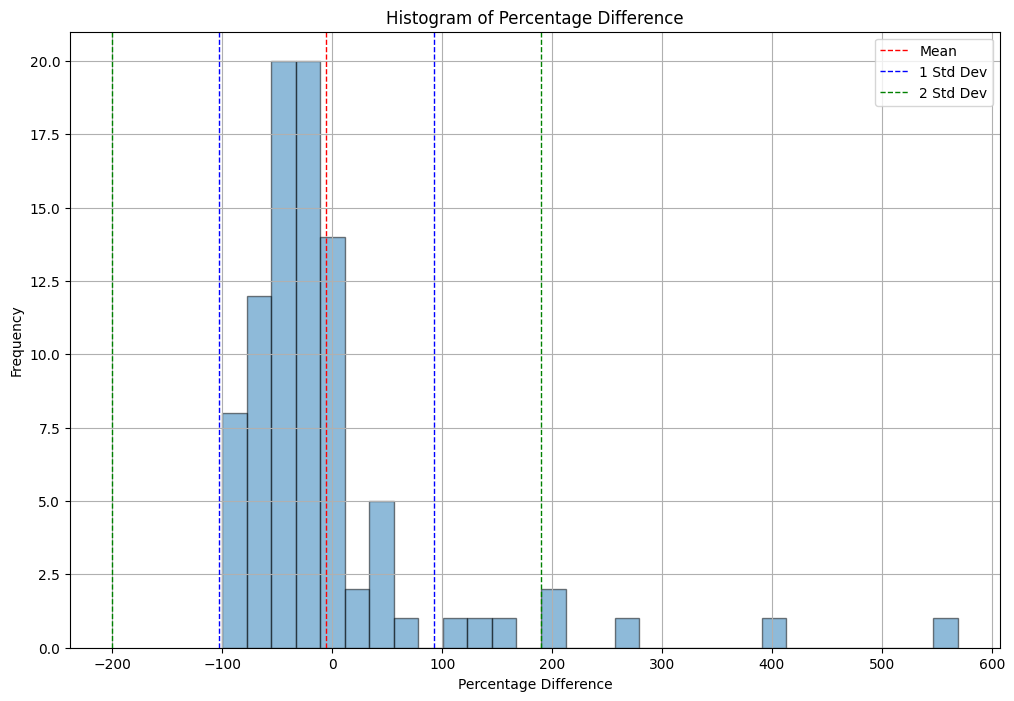

In [ ]:
# Calculate the standard deviation of 'Percentage Difference'
std_dev = np.std(sim_history_compare['Percentage Difference'])
mean_val = sim_history_compare['Percentage Difference'].mean()

print("Standard Deviation of Percentage Difference: ", std_dev)

# Plot the 'Percentage Difference'
plt.figure(figsize=(12, 8))
plt.hist(sim_history_compare['Percentage Difference'], bins=30, alpha=0.5, edgecolor='black')
plt.title('Histogram of Percentage Difference')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_val + std_dev, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev')
plt.axvline(mean_val - std_dev, color='b', linestyle='dashed', linewidth=1)
plt.axvline(mean_val + 2*std_dev, color='g', linestyle='dashed', linewidth=1, label='2 Std Dev')
plt.axvline(mean_val - 2*std_dev, color='g', linestyle='dashed', linewidth=1)
plt.legend()
plt.grid(True)
plt.show()


## Calculate standard deviation for Inventory on Hand delta %

In [ ]:
# Transform the list of dictionaries to a dictionary of DataFrames
results_dict = {item['moq_simulation_value']: item['result'] for item in results_array}

# Get the reference DataFrame (where moq_simulation_value is 1)
reference_df = results_dict[1]

# Initialize an empty DataFrame to store the results
comparison_df = pd.DataFrame(columns=['moq_simulation_value', 'Average Inventory on Hand delta %', 'Average Order Quantity delta %'])
delta_results = []

# Go through all the dataframes in the dictionary
for moq_value, df in results_dict.items():
    # if moq_value == 1:  # Skip the reference
    #     continue

    # Ignore the materials where the 'Average Inventory on Hand' or 'Total Order Quantity' in the reference dataframe is zero
    nonzero_inventory = reference_df['Average Inventory on Hand'] != 0
    nonzero_order_quantity = reference_df['Total Order Quantity'] != 0
    valid_materials = nonzero_inventory & nonzero_order_quantity

    # Calculate the absolute percentage difference for 'Average Inventory on Hand' and 'Total Order Quantity'
    inventory_diff = ((df.loc[valid_materials, 'Average Inventory on Hand'] - reference_df.loc[valid_materials, 'Average Inventory on Hand']) / reference_df.loc[valid_materials, 'Average Inventory on Hand']) * 100
    order_quantity_diff = ((df.loc[valid_materials, 'Total Order Quantity'] - reference_df.loc[valid_materials, 'Total Order Quantity']) / reference_df.loc[valid_materials, 'Total Order Quantity']) * 100

    # Calculate the average difference for all valid materials
    inventory_avg_diff = inventory_diff.mean()
    order_quantity_avg_diff = order_quantity_diff.mean()

    # Rounf inventory_avg_diff and order_quantity_avg_diff
    inventory_avg_diff = round(inventory_avg_diff, 2)
    order_quantity_avg_diff = round(order_quantity_avg_diff, 2)

    # Append the results to the comparison dataframe
    new_row = pd.DataFrame({'moq_simulation_value': [moq_value], 'Average Inventory on Hand delta %': [inventory_avg_diff], 'Average Order Quantity delta %': [order_quantity_avg_diff]})
    comparison_df = pd.concat([comparison_df, new_row])

    # delta_results.append([{'moq_simulation_value': moq_value, "inventory_diff": inventory_diff, "order_quantity_diff": order_quantity_diff}])
    delta_results.append({'moq_simulation_value': moq_value, "delta_result": pd.DataFrame({'inventory_diff': inventory_diff, 'order_quantity_diff': order_quantity_diff}) })


# Set moq_simulation_value as index
comparison_df.set_index('moq_simulation_value', inplace=True)

# Display the dataframe
display(comparison_df)


,Average Inventory on Hand delta %,Average Order Quantity delta %
moq_simulation_value,,
1,0.00,0.00
0.9,-5.33,-4.58
0.8,-12.43,-8.31
0.7,-19.34,-13.23
0.5,-31.92,-19.81


## Visualize standard deviation for Inventory on Hand delta %

In [ ]:
# Loop through delta_results
for result in delta_results:
    # Get moq_simulation_value and delta_result
    moq_simulation_value = result['moq_simulation_value']
    delta_result = result['delta_result']

    # Calculate standard deviation of inventory_diff using np.std
    inventory_diff_std = np.std(delta_result['inventory_diff'])

    # Calculate mean of inventory_diff
    inventory_diff_mean = delta_result['inventory_diff'].mean()

    # Print standard deviation
    display(f"Standard deviation of inventory_diff for moq_simulation_value = {moq_simulation_value} is {inventory_diff_std}")

    # Plot the 'inventory_diff'
    plt.figure(figsize=(12, 8))
    plt.hist(delta_result['inventory_diff'], bins=30, alpha=0.5, edgecolor='black')
    plt.title(f'Histogram of Inventory Difference for moq_simulation_value = {moq_simulation_value}')
    plt.xlabel('Inventory Difference')
    plt.ylabel('Frequency')
    plt.axvline(inventory_diff_mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(inventory_diff_mean + inventory_diff_std, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev')
    plt.axvline(inventory_diff_mean - inventory_diff_std, color='b', linestyle='dashed', linewidth=1)
    plt.axvline(inventory_diff_mean + 2*inventory_diff_std, color='g', linestyle='dashed', linewidth=1, label='2 Std Dev')
    plt.axvline(inventory_diff_mean - 2*inventory_diff_std, color='g', linestyle='dashed', linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()


## Standard deviation of fill rate

In [ ]:
# Loop through results_array
for result in results_array:
    # Get moq_simulation_value and result DataFrame
    moq_simulation_value = result['moq_simulation_value']
    sim_result = result['result']

    # Calculate standard deviation of Fill Rate using np.std
    fill_rate_std = np.std(sim_result['Fill Rate'])

    # Calculate mean of Fill Rate
    fill_rate_mean = sim_result['Fill Rate'].mean()

    # Print standard deviation
    print(f"Standard deviation of Fill Rate for moq_simulation_value = {moq_simulation_value} is {fill_rate_std:.4f}")

    # Plot the 'Fill Rate'
    plt.figure(figsize=(12, 8))
    plt.hist(sim_result['Fill Rate'], bins=30, alpha=0.5, edgecolor='black')
    plt.title(f'Histogram of Fill Rate for moq_simulation_value = {moq_simulation_value}')
    plt.xlabel('Fill Rate')
    plt.ylabel('Frequency')
    plt.axvline(fill_rate_mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(fill_rate_mean + fill_rate_std, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev')
    plt.axvline(fill_rate_mean - fill_rate_std, color='b', linestyle='dashed', linewidth=1)
    plt.axvline(fill_rate_mean + 2*fill_rate_std, color='g', linestyle='dashed', linewidth=1, label='2 Std Dev')
    plt.axvline(fill_rate_mean - 2*fill_rate_std, color='g', linestyle='dashed', linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
